In [1]:

import numpy as np
import pandas as pd
import os
data_path = "/kaggle/input/smai-25-sec-a-project-phase-2-lat-long-prediction"
images_train_path = os.path.join(data_path, 'images_train/images_train')
images_val_path = os.path.join(data_path, 'images_val/images_val')
labels_train = os.path.join(data_path, 'labels_train.csv')
labels_val = os.path.join(data_path, 'labels_val.csv')

df = pd.read_csv(labels_train)
# df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M').dt.time

print(df.head())


       filename timestamp  latitude  longitude  angle  Region_ID
0  img_0000.jpg     15:03    219698     144782    133          2
1  img_0001.jpg     15:05    219844     144621    312          2
2  img_0002.jpg     15:05    219844     144621    359          2
3  img_0003.jpg     17:11    219514     145016    131          2
4  img_0004.jpg     17:00    220182     144211     45          2


In [2]:
import cv2
import os
image = cv2.imread(os.path.join(images_train_path, df['filename'][0]))
print(image.shape)

# in the df change all the file names to full path
df['filename'] = df['filename'].apply(lambda x: os.path.join(images_train_path, x))
df.head()

(256, 256, 3)


,filename,timestamp,latitude,longitude,angle,Region_ID
0,/kaggle/input/smai-25-sec-a-project-phase-2-la...,15:03,219698,144782,133,2
1,/kaggle/input/smai-25-sec-a-project-phase-2-la...,15:05,219844,144621,312,2
2,/kaggle/input/smai-25-sec-a-project-phase-2-la...,15:05,219844,144621,359,2
3,/kaggle/input/smai-25-sec-a-project-phase-2-la...,17:11,219514,145016,131,2
4,/kaggle/input/smai-25-sec-a-project-phase-2-la...,17:00,220182,144211,45,2


In [3]:
validation_df = pd.read_csv(labels_val)
validation_df['filename'] = validation_df['filename'].apply(lambda x: os.path.join(images_val_path, x))
validation_df = validation_df.drop(index = [95, 145, 146, 158, 159, 160, 161])
validation_df.head()

,filename,timestamp,latitude,longitude,angle,Region_ID
0,/kaggle/input/smai-25-sec-a-project-phase-2-la...,15:04,219698,144782,311,2
1,/kaggle/input/smai-25-sec-a-project-phase-2-la...,17:00,220182,144211,89,2
2,/kaggle/input/smai-25-sec-a-project-phase-2-la...,17:00,220182,144211,177,2
3,/kaggle/input/smai-25-sec-a-project-phase-2-la...,15:11,220195,141942,301,12
4,/kaggle/input/smai-25-sec-a-project-phase-2-la...,17:35,220437,142673,323,12


In [4]:
from sklearn.metrics import pairwise_distances
import numpy as np

def region_stats(df):
    stats = []
    for rid in df['Region_ID'].unique():
        points = df[df['Region_ID'] == rid][['latitude', 'longitude']].values
        if len(points) > 1:
            dists = pairwise_distances(points)
            max_dist = np.max(dists)
            mean_dist = np.mean(dists)
        else:
            max_dist = mean_dist = 0
        stats.append((rid, len(points), max_dist, mean_dist))
    return pd.DataFrame(stats, columns=["Region_ID", "Count", "Max_Dist", "Mean_Dist"])

region_analysis = region_stats(df)
print(region_analysis)

    Region_ID  Count      Max_Dist      Mean_Dist
0           2    450  1.012865e+04     751.657454
1          12    445  2.416649e+05    6309.190108
2           4    461  1.388416e+03     532.938091
3           7    394  6.090242e+07  308851.529284
4          13    397  1.364368e+03     451.998721
5           3    444  2.837617e+03     692.484933
6           9    262  1.237534e+03     359.250390
7           5    484  1.094646e+03     318.842113
8          10    546  5.742510e+05    2818.749120
9           1    362  1.843007e+03     567.954472
10         11    403  3.021872e+04     729.656762
11          6    452  1.053657e+03     312.269036
12          8    503  2.322442e+05   41028.360253
13         15    773  1.465253e+05    2632.014311
14         14    166  4.782322e+02     204.132728


In [5]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

coords = df[['latitude', 'longitude']].values
coords_scaled = StandardScaler().fit_transform(coords)
db = DBSCAN(eps=0.5, min_samples=5).fit(coords_scaled)
df['spatial_cluster'] = db.labels_  # -1 will be noise

In [6]:
region_latlong_stats = df.groupby("Region_ID")[["latitude", "longitude"]].agg(['mean', 'var']).reset_index()

# Flatten column names
region_latlong_stats.columns = ['Region_ID', 'lat_mean', 'lat_var', 'long_mean', 'long_var']

# Display the result
print(region_latlong_stats)

    Region_ID       lat_mean       lat_var      long_mean      long_var
0           1  218784.980663  1.230970e+05  145322.859116  1.169858e+05
1           2  219705.560000  1.668544e+05  144761.495556  4.119892e+05
2           3  219815.085586  1.689265e+05  144784.907658  1.984196e+05
3           4  219930.791757  5.017959e+04  143903.828633  1.421330e+05
4           5  218627.630165  3.086892e+04  144384.725207  4.434258e+04
5           6  219166.349558  2.926520e+04  143734.561947  4.190532e+04
6           7  374498.129442  9.413712e+12  142739.243655  1.095469e+05
7           8  202627.846918  2.920591e+09  129756.439364  1.815389e+09
8           9  220857.927481  4.052839e+04  143421.854962  5.625698e+04
9          10  221163.347985  8.940278e+04  144092.547619  5.887626e+08
10         11  220864.866005  4.476552e+06  142594.399504  6.612330e+04
11         12  217566.674157  5.391444e+08  141412.838202  4.652718e+07
12         13  219334.926952  8.248318e+04  141322.166247  7.086

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def clean_latlong_by_region(df, eps=0.3, min_samples=25):
    df_clean = []
    for rid in df['Region_ID'].unique():
        region_df = df[df['Region_ID'] == rid].copy()
        coords = region_df[['latitude', 'longitude']].values
        if len(coords) < min_samples:
            region_df['is_outlier'] = False
            df_clean.append(region_df)
            continue
        coords_scaled = StandardScaler().fit_transform(coords)
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords_scaled)
        region_df['is_outlier'] = clustering.labels_ == -1
        df_clean.append(region_df)
    return pd.concat(df_clean)

# Adjust eps/min_samples as needed
df_result = clean_latlong_by_region(df, eps=0.5, min_samples=10)
df_result = df_result[df_result['is_outlier'] == False]

In [8]:
from sklearn.metrics import pairwise_distances
import numpy as np

def region_stats(df):
    stats = []
    for rid in df['Region_ID'].unique():
        points = df[df['Region_ID'] == rid][['latitude', 'longitude']].values
        if len(points) > 1:
            dists = pairwise_distances(points)
            max_dist = np.max(dists)
            mean_dist = np.mean(dists)
        else:
            max_dist = mean_dist = 0
        stats.append((rid, len(points), max_dist, mean_dist))
    return pd.DataFrame(stats, columns=["Region_ID", "Count", "Max_Dist", "Mean_Dist"])
region_analysis2 = region_stats(df)
print(region_analysis2)
region_analysis1 = region_stats(df_result)
print(region_analysis1)

    Region_ID  Count      Max_Dist      Mean_Dist
0           2    450  1.012865e+04     751.657454
1          12    445  2.416649e+05    6309.190108
2           4    461  1.388416e+03     532.938091
3           7    394  6.090242e+07  308851.529284
4          13    397  1.364368e+03     451.998721
5           3    444  2.837617e+03     692.484933
6           9    262  1.237534e+03     359.250390
7           5    484  1.094646e+03     318.842113
8          10    546  5.742510e+05    2818.749120
9           1    362  1.843007e+03     567.954472
10         11    403  3.021872e+04     729.656762
11          6    452  1.053657e+03     312.269036
12          8    503  2.322442e+05   41028.360253
13         15    773  1.465253e+05    2632.014311
14         14    166  4.782322e+02     204.132728
    Region_ID  Count       Max_Dist     Mean_Dist
0           2    449    1990.386897    713.212244
1          12    437    1530.627649    428.177488
2           4    461    1388.416364    532.938091


In [9]:
region_latlong_stats = df.groupby("Region_ID")[["latitude", "longitude"]].agg(['mean', 'var']).reset_index()

# Flatten column names
region_latlong_stats.columns = ['Region_ID', 'lat_mean', 'lat_var', 'long_mean', 'long_var']

# Display the result
print(region_latlong_stats)

region_latlong_stats = df_result.groupby("Region_ID")[["latitude", "longitude"]].agg(['mean', 'var']).reset_index()

# Flatten column names
region_latlong_stats.columns = ['Region_ID', 'lat_mean', 'lat_var', 'long_mean', 'long_var']

# Display the result
print(region_latlong_stats)

    Region_ID       lat_mean       lat_var      long_mean      long_var
0           1  218784.980663  1.230970e+05  145322.859116  1.169858e+05
1           2  219705.560000  1.668544e+05  144761.495556  4.119892e+05
2           3  219815.085586  1.689265e+05  144784.907658  1.984196e+05
3           4  219930.791757  5.017959e+04  143903.828633  1.421330e+05
4           5  218627.630165  3.086892e+04  144384.725207  4.434258e+04
5           6  219166.349558  2.926520e+04  143734.561947  4.190532e+04
6           7  374498.129442  9.413712e+12  142739.243655  1.095469e+05
7           8  202627.846918  2.920591e+09  129756.439364  1.815389e+09
8           9  220857.927481  4.052839e+04  143421.854962  5.625698e+04
9          10  221163.347985  8.940278e+04  144092.547619  5.887626e+08
10         11  220864.866005  4.476552e+06  142594.399504  6.612330e+04
11         12  217566.674157  5.391444e+08  141412.838202  4.652718e+07
12         13  219334.926952  8.248318e+04  141322.166247  7.086

In [10]:
import numpy as np

region_id_to_clean = 8
threshold = 1.5 
region_data = df_result[df_result['Region_ID'] == region_id_to_clean].copy()

lat_mean = region_data['latitude'].mean()
lat_std = region_data['latitude'].std()
long_mean = region_data['longitude'].mean()
long_std = region_data['longitude'].std()
lat_mask = (region_data['latitude'] >= lat_mean - threshold * lat_std) & (region_data['latitude'] <= lat_mean + threshold * lat_std)
long_mask = (region_data['longitude'] >= long_mean - threshold * long_std) & (region_data['longitude'] <= long_mean + threshold * long_std)

combined_mask = lat_mask & long_mask

cleaned_region_8 = region_data[combined_mask].copy()

df_cleaned = df_result[df_result['Region_ID'] != region_id_to_clean].copy()
df_cleaned = pd.concat([df_cleaned, cleaned_region_8], ignore_index=True)

In [11]:
df_cleaned
df_cleaned = df_cleaned[df_cleaned['longitude'] >= 140000]

In [15]:
import matplotlib.pyplot as plt 

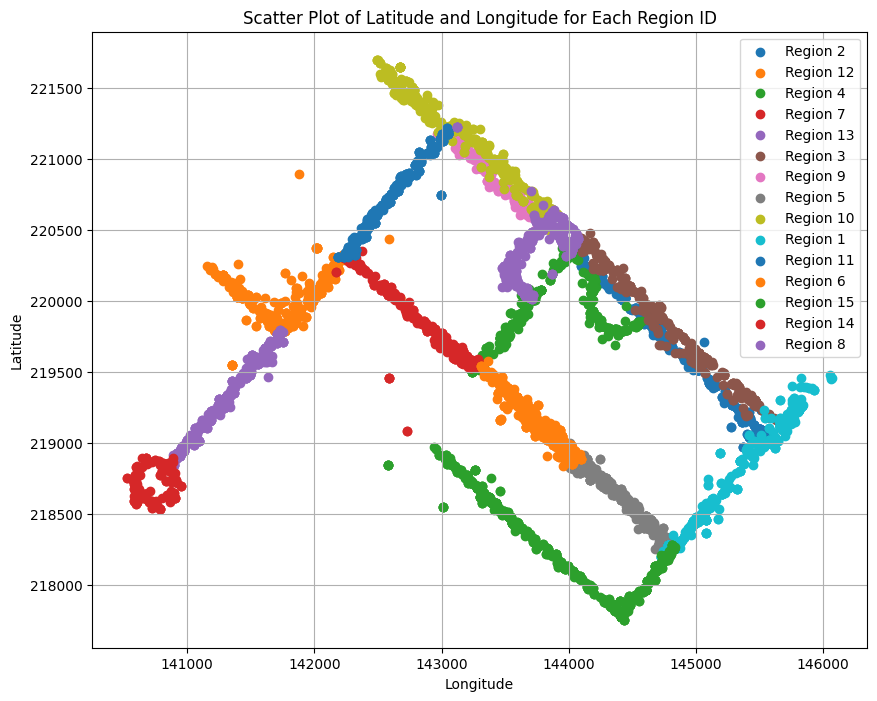

In [16]:
plt.figure(figsize=(10, 8))
for region_id in df_cleaned['Region_ID'].unique():
    region_data = df_cleaned[df_cleaned['Region_ID'] == region_id]
    plt.scatter(region_data['longitude'], region_data['latitude'], label=f'Region {region_id}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Latitude and Longitude for Each Region ID')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
mean_lat = df_cleaned['latitude'].mean()
mean_lon = df_cleaned['longitude'].mean()
std_lat = df_cleaned['latitude'].std()
std_lon = df_cleaned['longitude'].std()

# printing for sanity check 
vmean_lat = validation_df['latitude'].mean()
vmean_lon = validation_df['longitude'].mean()
vstd_lat = validation_df['latitude'].std()
vstd_lon = validation_df['longitude'].std()

print(f"df_cleaned mean latitude:  {mean_lat:.4f}")
print(f"df_cleaned mean longitude: {mean_lon:.4f}")
print(f"df_cleaned std latitude:   {std_lat:.4f}")
print(f"df_cleaned std longitude:  {std_lon:.4f}")

print("val")
print(f"mean latitude:  {vmean_lat:.4f}")
print(f"mean longitude: {vmean_lon:.4f}")
print(f"std latitude:   {vstd_lat:.4f}")
print(f"std longitude:  {vstd_lon:.4f}")
# we see that it is similar 

# 2. Normalize df_cleaned
df_cleaned['latitude_norm'] = (df_cleaned['latitude'] - mean_lat) / std_lat
df_cleaned['longitude_norm'] = (df_cleaned['longitude'] - mean_lon) / std_lon

# 3. Normalize validation_df using same mean and std
validation_df['latitude_norm'] = (validation_df['latitude'] - mean_lat) / std_lat
validation_df['longitude_norm'] = (validation_df['longitude'] - mean_lon) / std_lon

# Optional sanity check
print("\nFirst 5 normalized validation_df rows:")
print(validation_df[['latitude_norm', 'longitude_norm']].head())

df_cleaned mean latitude:  219659.3896
df_cleaned mean longitude: 143503.1669
df_cleaned std latitude:   917.2809
df_cleaned std longitude:  1187.6266
val
mean latitude:  219666.8812
mean longitude: 143474.8978
std latitude:   903.4316
std longitude:  1191.7073

First 5 normalized validation_df rows:
   latitude_norm  longitude_norm
0       0.042092        1.076797
1       0.569739        0.596006
2       0.569739        0.596006
3       0.583911       -1.314527
4       0.847734       -0.699013


In [18]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])
# can add a randomposterize 
# random adjust sharpness 
# random autocontrast 

train_transforms_2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAutocontrast(),
    # transforms.RandomAdjustSharpness(sharpness_factor=2),
    # transforms.RandomPosterize(bits=4),
    transforms.ToTensor()
])
train_transforms_3 = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomAutocontrast(),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    # transforms.RandomPosterize(bits=4),
    transforms.ToTensor()
])
train_transforms_4 = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomAutocontrast(),
    # transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomPosterize(bits=4),
    transforms.ToTensor()
])

In [19]:
from torch.utils.data import Dataset
from PIL import Image

In [20]:
class MyDataset(Dataset):
    def __init__(self, df, transform1=None, transform2 = None, transform3=None, transform4 = None,validation=False):
        self.df = df
        self.transform1 = transform1
        self.transform2 = transform2 
        self.transform3 = transform3
        self.transform4 = transform4 
        self.triple_len = len(df) * 5
        self.validation = validation
    

    def __len__(self):
        if self.validation:
            return len(self.df)
        else:
            return self.triple_len

    def __getitem__(self, idx):
        row = self.df.iloc[idx % len(self.df)]
        img = Image.open(f"{row.filename}").convert('RGB')
        img = img.resize((224, 224))

        if self.validation or idx % len(self.df) == 0:
            transformed_img = transforms.ToTensor()(img)
        elif idx > len(self.df) and idx < 2 * len(self.df):
            transformed_img = self.transform1(img) if self.transform1 else transforms.ToTensor()(img)
        elif idx > 2* len(self.df) and idx < 3 * len(self.df):
            transformed_img = self.transform2(img) if self.transform2 else transforms.ToTensor()(img)
        elif idx > 3*len(self.df) and idx < 4 * len(self.df):
            transformed_img = self.transform3(img) if self.transform3 else transforms.ToTensor()(img)
        else:
            transformed_img = self.transform4(img) if self.transform4 else transforms.ToTensor()(img)

        label_latitude = row['latitude_norm']
        label_longitude = row['longitude_norm']
        return transformed_img, label_latitude, label_longitude


train_dataset = MyDataset(df_cleaned, transform1=train_transforms, transform2 = train_transforms_2,
                          transform3=train_transforms_3, transform4 = train_transforms_4) 
print(len(train_dataset))
# img_sample, label = train_dataset[len(df) + 4]
# print(img_sample.shape)
# print(label)
validation_dataset = MyDataset(validation_df, validation=True)

print(len(validation_dataset))
# img_sample, label = validation_dataset[0]
# print(img_sample.shape)
# print(label)

32145
362


In [21]:
import torch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)
# device = 
print(len(train_loader))
print(len(validation_loader))
# print(device)
print(train_loader.dataset[0][0].shape)
# sample_image, sample_label = train_loader.dataset[0]

1005
12
torch.Size([3, 224, 224])


In [22]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import os
from tqdm import tqdm


In [24]:


import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb-key")

wandb.login(key = secret_value_0)

wandb.init(
    project = "smai-latlongprediction",
    name = 'v2_simplerno_earlystopping_efficientnetb0-partialfinetuning'
)



wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: v4ishnavi (v4ishnavi-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [25]:
MEAN_LAT, STD_LAT = 219659.3896, 917.2809
MEAN_LON, STD_LON = 143503.1669, 1187.6266

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

In [26]:
model = models.efficientnet_b0(pretrained=True)
in_feats = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_feats, 2)     # output: [lat_norm, lon_norm]
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s] 


In [28]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)
criterion = nn.MSELoss()
num_epochs = 75
best_eval_metric = float('inf')

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [29]:
patience_count = num_epochs # basically a lot of patience 
patience_counter = 0
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    # ——— Training ———
    model.train()
    train_loss_norm = 0.0
    for imgs, lat_norm, lon_norm in tqdm(train_loader, desc="Train"):
        imgs = imgs.to(device)
        labels_norm = torch.stack([lat_norm, lon_norm], dim=1).float().to(device)  # (B,2)

        optimizer.zero_grad()
        preds_norm = model(imgs)                                       # (B,2)
        loss = criterion(preds_norm, labels_norm)
        loss.backward()
        optimizer.step()

        train_loss_norm += loss.item() * imgs.size(0)

    avg_train_loss_norm = train_loss_norm / len(train_loader.dataset)
    print(f"→ Avg Train Loss (norm-space): {avg_train_loss_norm:.6f}")

    # ——— Validation ———
    model.eval()
    val_loss_norm = 0.0
    all_preds_norm, all_tgts_norm = [], []

    with torch.no_grad():
        for imgs, lat_norm, lon_norm in tqdm(validation_loader, desc="Val"):
            imgs = imgs.to(device)
            labels_norm = torch.stack([lat_norm, lon_norm], dim=1).to(device)

            preds_norm = model(imgs)
            loss = criterion(preds_norm, labels_norm)
            val_loss_norm += loss.item() * imgs.size(0)

            all_preds_norm.append(preds_norm)
            all_tgts_norm.append(labels_norm)

    avg_val_loss_norm = val_loss_norm / len(validation_loader.dataset)
    print(f"→ Avg Val   Loss (norm-space): {avg_val_loss_norm:.6f}")

    # ——— Rescale & Final Metric ———
    preds_norm_cat   = torch.cat(all_preds_norm,   dim=0)
    tgts_norm_cat    = torch.cat(all_tgts_norm,    dim=0)

    # rescale back
    pred_lat = preds_norm_cat[:,0] * STD_LAT + MEAN_LAT
    pred_lon = preds_norm_cat[:,1] * STD_LON + MEAN_LON
    tgt_lat  = tgts_norm_cat[:,0]   * STD_LAT + MEAN_LAT
    tgt_lon  = tgts_norm_cat[:,1]   * STD_LON + MEAN_LON

    mse_lat = torch.mean((pred_lat - tgt_lat)**2)
    mse_lon = torch.mean((pred_lon - tgt_lon)**2)
    final_eval = 0.5 * mse_lat + 0.5 * mse_lon

    print(f"→ Val MSE_lat: {mse_lat:.4f}, MSE_lon: {mse_lon:.4f}")
    print(f"→ Final Eval (½·MSE_lat + ½·MSE_lon): {final_eval:.4f}")

    # ——— WandB Logging ———
    wandb.log({
        'epoch': epoch+1,
        'train_loss_norm': avg_train_loss_norm,
        'val_loss_norm'  : avg_val_loss_norm,
        'val_mse_lat'    : mse_lat.item(),
        'val_mse_lon'    : mse_lon.item(),
        'val_final_eval' : final_eval.item(),
        'learning_rate'  : optimizer.param_groups[0]['lr'],
    })

    scheduler.step(avg_val_loss_norm)

    # Save best
    if final_eval < best_eval_metric:
        best_eval_metric = final_eval
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_latlon_eb0.pth')
        name = f"efficientnet-latlong-temp-{epoch}"
        artifact = wandb.Artifact(name, type = 'model')
        artifact.add_file('best_model_latlon_eb0.pth')
        wandb.log_artifact(artifact)
        print("✅ Improved! Saved new best model.")
    else:
        patience_counter = patience_counter + 1 
        print("patience count :", patience_counter)

    # Early stop
    if patience_counter >= patience_count :
        print("⛔ Early stopping.")
        break


artifact = wandb.Artifact('efficientnet-latlong', type='model')
artifact.add_file('best_model_latlon_eb0.pth')
wandb.log_artifact(artifact)



Epoch 1/75
------------------------------


Train: 100%|██████████| 1005/1005 [07:01<00:00,  2.38it/s]


→ Avg Train Loss (norm-space): 0.247943


Val: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


→ Avg Val   Loss (norm-space): 0.185583
→ Val MSE_lat: 194835.9031, MSE_lon: 196907.9036
→ Final Eval (½·MSE_lat + ½·MSE_lon): 195871.9034
✅ Improved! Saved new best model.

Epoch 2/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:15<00:00,  2.68it/s]


→ Avg Train Loss (norm-space): 0.094177


Val: 100%|██████████| 12/12 [00:02<00:00,  4.03it/s]


→ Avg Val   Loss (norm-space): 0.135551
→ Val MSE_lat: 133943.9275, MSE_lon: 157846.1425
→ Final Eval (½·MSE_lat + ½·MSE_lon): 145895.0350
✅ Improved! Saved new best model.

Epoch 3/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:14<00:00,  2.68it/s]


→ Avg Train Loss (norm-space): 0.084494


Val: 100%|██████████| 12/12 [00:02<00:00,  4.12it/s]


→ Avg Val   Loss (norm-space): 0.135961
→ Val MSE_lat: 137148.3902, MSE_lon: 153631.5743
→ Final Eval (½·MSE_lat + ½·MSE_lon): 145389.9822
✅ Improved! Saved new best model.

Epoch 4/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:15<00:00,  2.68it/s]


→ Avg Train Loss (norm-space): 0.060048


Val: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s]


→ Avg Val   Loss (norm-space): 0.106613
→ Val MSE_lat: 108066.7177, MSE_lon: 119591.5669
→ Final Eval (½·MSE_lat + ½·MSE_lon): 113829.1423
✅ Improved! Saved new best model.

Epoch 5/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:13<00:00,  2.69it/s]


→ Avg Train Loss (norm-space): 0.049835


Val: 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]


→ Avg Val   Loss (norm-space): 0.118416
→ Val MSE_lat: 107761.3535, MSE_lon: 153401.3885
→ Final Eval (½·MSE_lat + ½·MSE_lon): 130581.3710
patience count : 1

Epoch 6/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:11<00:00,  2.71it/s]


→ Avg Train Loss (norm-space): 0.061603


Val: 100%|██████████| 12/12 [00:02<00:00,  4.02it/s]


→ Avg Val   Loss (norm-space): 0.111520
→ Val MSE_lat: 106730.8897, MSE_lon: 135673.7406
→ Final Eval (½·MSE_lat + ½·MSE_lon): 121202.3151
patience count : 2

Epoch 7/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:13<00:00,  2.69it/s]


→ Avg Train Loss (norm-space): 0.037056


Val: 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]


→ Avg Val   Loss (norm-space): 0.070771
→ Val MSE_lat: 62261.5831, MSE_lon: 95268.4554
→ Final Eval (½·MSE_lat + ½·MSE_lon): 78765.0192
✅ Improved! Saved new best model.

Epoch 8/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:09<00:00,  2.72it/s]


→ Avg Train Loss (norm-space): 0.042022


Val: 100%|██████████| 12/12 [00:03<00:00,  3.91it/s]


→ Avg Val   Loss (norm-space): 0.104416
→ Val MSE_lat: 81967.9184, MSE_lon: 157144.9357
→ Final Eval (½·MSE_lat + ½·MSE_lon): 119556.4271
patience count : 1

Epoch 9/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:13<00:00,  2.69it/s]


→ Avg Train Loss (norm-space): 0.042738


Val: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]


→ Avg Val   Loss (norm-space): 0.089553
→ Val MSE_lat: 85835.7819, MSE_lon: 108734.8930
→ Final Eval (½·MSE_lat + ½·MSE_lon): 97285.3374
patience count : 2

Epoch 10/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:11<00:00,  2.70it/s]


→ Avg Train Loss (norm-space): 0.035437


Val: 100%|██████████| 12/12 [00:02<00:00,  4.57it/s]


→ Avg Val   Loss (norm-space): 0.077038
→ Val MSE_lat: 68436.9023, MSE_lon: 102596.1897
→ Final Eval (½·MSE_lat + ½·MSE_lon): 85516.5460
patience count : 3

Epoch 11/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:09<00:00,  2.72it/s]


→ Avg Train Loss (norm-space): 0.013778


Val: 100%|██████████| 12/12 [00:02<00:00,  4.21it/s]


→ Avg Val   Loss (norm-space): 0.051762
→ Val MSE_lat: 41460.8396, MSE_lon: 76513.1242
→ Final Eval (½·MSE_lat + ½·MSE_lon): 58986.9819
✅ Improved! Saved new best model.

Epoch 12/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:09<00:00,  2.72it/s]


→ Avg Train Loss (norm-space): 0.010985


Val: 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]


→ Avg Val   Loss (norm-space): 0.053803
→ Val MSE_lat: 35307.5268, MSE_lon: 92586.3486
→ Final Eval (½·MSE_lat + ½·MSE_lon): 63946.9377
patience count : 1

Epoch 13/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:07<00:00,  2.74it/s]


→ Avg Train Loss (norm-space): 0.009513


Val: 100%|██████████| 12/12 [00:02<00:00,  4.54it/s]


→ Avg Val   Loss (norm-space): 0.084189
→ Val MSE_lat: 89869.9154, MSE_lon: 86838.1695
→ Final Eval (½·MSE_lat + ½·MSE_lon): 88354.0424
patience count : 2

Epoch 14/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:12<00:00,  2.70it/s]


→ Avg Train Loss (norm-space): 0.013374


Val: 100%|██████████| 12/12 [00:02<00:00,  4.73it/s]


→ Avg Val   Loss (norm-space): 0.067996
→ Val MSE_lat: 46179.9063, MSE_lon: 114397.8029
→ Final Eval (½·MSE_lat + ½·MSE_lon): 80288.8546
patience count : 3

Epoch 15/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:08<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.006943


Val: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s]


→ Avg Val   Loss (norm-space): 0.059771
→ Val MSE_lat: 36391.3764, MSE_lon: 107606.8060
→ Final Eval (½·MSE_lat + ½·MSE_lon): 71999.0912
patience count : 4

Epoch 16/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:06<00:00,  2.74it/s]


→ Avg Train Loss (norm-space): 0.005485


Val: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s]


→ Avg Val   Loss (norm-space): 0.047147
→ Val MSE_lat: 35447.2490, MSE_lon: 73578.0691
→ Final Eval (½·MSE_lat + ½·MSE_lon): 54512.6591
✅ Improved! Saved new best model.

Epoch 17/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:04<00:00,  2.75it/s]


→ Avg Train Loss (norm-space): 0.005218


Val: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s]


→ Avg Val   Loss (norm-space): 0.053333
→ Val MSE_lat: 35639.6993, MSE_lon: 90703.5361
→ Final Eval (½·MSE_lat + ½·MSE_lon): 63171.6177
patience count : 1

Epoch 18/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:07<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.006038


Val: 100%|██████████| 12/12 [00:02<00:00,  4.50it/s]


→ Avg Val   Loss (norm-space): 0.059953
→ Val MSE_lat: 37536.8046, MSE_lon: 106198.7626
→ Final Eval (½·MSE_lat + ½·MSE_lon): 71867.7836
patience count : 2

Epoch 19/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:10<00:00,  2.72it/s]


→ Avg Train Loss (norm-space): 0.004959


Val: 100%|██████████| 12/12 [00:02<00:00,  4.47it/s]


→ Avg Val   Loss (norm-space): 0.052265
→ Val MSE_lat: 34599.5149, MSE_lon: 89435.3024
→ Final Eval (½·MSE_lat + ½·MSE_lon): 62017.4086
patience count : 3

Epoch 20/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:06<00:00,  2.74it/s]


→ Avg Train Loss (norm-space): 0.003652


Val: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s]


→ Avg Val   Loss (norm-space): 0.042323
→ Val MSE_lat: 33025.1500, MSE_lon: 64028.6299
→ Final Eval (½·MSE_lat + ½·MSE_lon): 48526.8899
✅ Improved! Saved new best model.

Epoch 21/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:09<00:00,  2.72it/s]


→ Avg Train Loss (norm-space): 0.003655


Val: 100%|██████████| 12/12 [00:02<00:00,  4.64it/s]


→ Avg Val   Loss (norm-space): 0.045860
→ Val MSE_lat: 27179.0616, MSE_lon: 83805.5958
→ Final Eval (½·MSE_lat + ½·MSE_lon): 55492.3287
patience count : 1

Epoch 22/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:09<00:00,  2.72it/s]


→ Avg Train Loss (norm-space): 0.003247


Val: 100%|██████████| 12/12 [00:02<00:00,  4.37it/s]


→ Avg Val   Loss (norm-space): 0.044015
→ Val MSE_lat: 24559.8741, MSE_lon: 82993.8463
→ Final Eval (½·MSE_lat + ½·MSE_lon): 53776.8602
patience count : 2

Epoch 23/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:08<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.003028


Val: 100%|██████████| 12/12 [00:02<00:00,  4.76it/s]


→ Avg Val   Loss (norm-space): 0.051586
→ Val MSE_lat: 28236.1836, MSE_lon: 98188.2532
→ Final Eval (½·MSE_lat + ½·MSE_lon): 63212.2184
patience count : 3

Epoch 24/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:08<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.002741


Val: 100%|██████████| 12/12 [00:02<00:00,  4.52it/s]


→ Avg Val   Loss (norm-space): 0.045079
→ Val MSE_lat: 28616.1535, MSE_lon: 79195.1719
→ Final Eval (½·MSE_lat + ½·MSE_lon): 53905.6627
patience count : 4

Epoch 25/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:07<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.002667


Val: 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]


→ Avg Val   Loss (norm-space): 0.047398
→ Val MSE_lat: 29527.8384, MSE_lon: 84208.3191
→ Final Eval (½·MSE_lat + ½·MSE_lon): 56868.0788
patience count : 5

Epoch 26/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:07<00:00,  2.74it/s]


→ Avg Train Loss (norm-space): 0.002564


Val: 100%|██████████| 12/12 [00:02<00:00,  4.15it/s]


→ Avg Val   Loss (norm-space): 0.043440
→ Val MSE_lat: 34929.1515, MSE_lon: 63987.9569
→ Final Eval (½·MSE_lat + ½·MSE_lon): 49458.5542
patience count : 6

Epoch 27/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:08<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.002460


Val: 100%|██████████| 12/12 [00:02<00:00,  4.13it/s]


→ Avg Val   Loss (norm-space): 0.048003
→ Val MSE_lat: 31469.8477, MSE_lon: 82657.9053
→ Final Eval (½·MSE_lat + ½·MSE_lon): 57063.8765
patience count : 7

Epoch 28/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:08<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.002284


Val: 100%|██████████| 12/12 [00:02<00:00,  4.03it/s]


→ Avg Val   Loss (norm-space): 0.047597
→ Val MSE_lat: 29975.5897, MSE_lon: 84019.2026
→ Final Eval (½·MSE_lat + ½·MSE_lon): 56997.3962
patience count : 8

Epoch 29/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:09<00:00,  2.72it/s]


→ Avg Train Loss (norm-space): 0.002280


Val: 100%|██████████| 12/12 [00:02<00:00,  4.21it/s]


→ Avg Val   Loss (norm-space): 0.046615
→ Val MSE_lat: 27959.1144, MSE_lon: 84628.6727
→ Final Eval (½·MSE_lat + ½·MSE_lon): 56293.8935
patience count : 9

Epoch 30/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:11<00:00,  2.71it/s]


→ Avg Train Loss (norm-space): 0.002177


Val: 100%|██████████| 12/12 [00:02<00:00,  4.06it/s]


→ Avg Val   Loss (norm-space): 0.042049
→ Val MSE_lat: 27785.1526, MSE_lon: 72039.3795
→ Final Eval (½·MSE_lat + ½·MSE_lon): 49912.2661
patience count : 10

Epoch 31/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:11<00:00,  2.70it/s]


→ Avg Train Loss (norm-space): 0.002195


Val: 100%|██████████| 12/12 [00:02<00:00,  4.24it/s]


→ Avg Val   Loss (norm-space): 0.042953
→ Val MSE_lat: 27140.5663, MSE_lon: 75671.6748
→ Final Eval (½·MSE_lat + ½·MSE_lon): 51406.1206
patience count : 11

Epoch 32/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:10<00:00,  2.71it/s]


→ Avg Train Loss (norm-space): 0.002150


Val: 100%|██████████| 12/12 [00:02<00:00,  4.15it/s]


→ Avg Val   Loss (norm-space): 0.044457
→ Val MSE_lat: 28014.1448, MSE_lon: 78449.8088
→ Final Eval (½·MSE_lat + ½·MSE_lon): 53231.9768
patience count : 12

Epoch 33/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:10<00:00,  2.71it/s]


→ Avg Train Loss (norm-space): 0.002140


Val: 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]


→ Avg Val   Loss (norm-space): 0.046718
→ Val MSE_lat: 26783.9600, MSE_lon: 86890.2753
→ Final Eval (½·MSE_lat + ½·MSE_lon): 56837.1176
patience count : 13

Epoch 34/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:08<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.002084


Val: 100%|██████████| 12/12 [00:02<00:00,  4.04it/s]


→ Avg Val   Loss (norm-space): 0.041093
→ Val MSE_lat: 24298.2458, MSE_lon: 75188.5011
→ Final Eval (½·MSE_lat + ½·MSE_lon): 49743.3735
patience count : 14

Epoch 35/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:07<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.002041


Val: 100%|██████████| 12/12 [00:02<00:00,  4.25it/s]


→ Avg Val   Loss (norm-space): 0.044812
→ Val MSE_lat: 27876.9003, MSE_lon: 79680.7396
→ Final Eval (½·MSE_lat + ½·MSE_lon): 53778.8199
patience count : 15

Epoch 36/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:09<00:00,  2.72it/s]


→ Avg Train Loss (norm-space): 0.002035


Val: 100%|██████████| 12/12 [00:03<00:00,  3.90it/s]


→ Avg Val   Loss (norm-space): 0.043335
→ Val MSE_lat: 26684.7106, MSE_lon: 77513.1602
→ Final Eval (½·MSE_lat + ½·MSE_lon): 52098.9354
patience count : 16

Epoch 37/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:08<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.002027


Val: 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]


→ Avg Val   Loss (norm-space): 0.041428
→ Val MSE_lat: 25531.0849, MSE_lon: 74067.9298
→ Final Eval (½·MSE_lat + ½·MSE_lon): 49799.5074
patience count : 17

Epoch 38/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:09<00:00,  2.72it/s]


→ Avg Train Loss (norm-space): 0.002001


Val: 100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


→ Avg Val   Loss (norm-space): 0.043214
→ Val MSE_lat: 24378.4990, MSE_lon: 81036.3412
→ Final Eval (½·MSE_lat + ½·MSE_lon): 52707.4201
patience count : 18

Epoch 39/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:07<00:00,  2.74it/s]


→ Avg Train Loss (norm-space): 0.002023


Val: 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]


→ Avg Val   Loss (norm-space): 0.044385
→ Val MSE_lat: 26234.4599, MSE_lon: 81229.2607
→ Final Eval (½·MSE_lat + ½·MSE_lon): 53731.8603
patience count : 19

Epoch 40/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:05<00:00,  2.75it/s]


→ Avg Train Loss (norm-space): 0.001995


Val: 100%|██████████| 12/12 [00:02<00:00,  4.02it/s]


→ Avg Val   Loss (norm-space): 0.046073
→ Val MSE_lat: 27381.9976, MSE_lon: 84066.1104
→ Final Eval (½·MSE_lat + ½·MSE_lon): 55724.0540
patience count : 20

Epoch 41/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:08<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.002001


Val: 100%|██████████| 12/12 [00:02<00:00,  4.04it/s]


→ Avg Val   Loss (norm-space): 0.043761
→ Val MSE_lat: 29620.3153, MSE_lon: 73791.9971
→ Final Eval (½·MSE_lat + ½·MSE_lon): 51706.1562
patience count : 21

Epoch 42/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:05<00:00,  2.75it/s]


→ Avg Train Loss (norm-space): 0.001996


Val: 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]


→ Avg Val   Loss (norm-space): 0.040226
→ Val MSE_lat: 26618.8500, MSE_lon: 68851.8017
→ Final Eval (½·MSE_lat + ½·MSE_lon): 47735.3258
✅ Improved! Saved new best model.

Epoch 43/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:06<00:00,  2.74it/s]


→ Avg Train Loss (norm-space): 0.002002


Val: 100%|██████████| 12/12 [00:02<00:00,  4.22it/s]


→ Avg Val   Loss (norm-space): 0.040854
→ Val MSE_lat: 27326.2866, MSE_lon: 69439.3060
→ Final Eval (½·MSE_lat + ½·MSE_lon): 48382.7963
patience count : 1

Epoch 44/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:06<00:00,  2.75it/s]


→ Avg Train Loss (norm-space): 0.001977


Val: 100%|██████████| 12/12 [00:03<00:00,  3.99it/s]


→ Avg Val   Loss (norm-space): 0.041981
→ Val MSE_lat: 25661.4569, MSE_lon: 75407.0554
→ Final Eval (½·MSE_lat + ½·MSE_lon): 50534.2562
patience count : 2

Epoch 45/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:07<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.001989


Val: 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]


→ Avg Val   Loss (norm-space): 0.042775
→ Val MSE_lat: 24159.7233, MSE_lon: 80166.6582
→ Final Eval (½·MSE_lat + ½·MSE_lon): 52163.1907
patience count : 3

Epoch 46/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:04<00:00,  2.76it/s]


→ Avg Train Loss (norm-space): 0.001967


Val: 100%|██████████| 12/12 [00:03<00:00,  3.97it/s]


→ Avg Val   Loss (norm-space): 0.041657
→ Val MSE_lat: 25047.8726, MSE_lon: 75524.1236
→ Final Eval (½·MSE_lat + ½·MSE_lon): 50285.9981
patience count : 4

Epoch 47/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:05<00:00,  2.75it/s]


→ Avg Train Loss (norm-space): 0.001991


Val: 100%|██████████| 12/12 [00:02<00:00,  4.19it/s]


→ Avg Val   Loss (norm-space): 0.044415
→ Val MSE_lat: 25370.7522, MSE_lon: 82760.8374
→ Final Eval (½·MSE_lat + ½·MSE_lon): 54065.7948
patience count : 5

Epoch 48/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:08<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.001991


Val: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s]


→ Avg Val   Loss (norm-space): 0.043370
→ Val MSE_lat: 24843.3719, MSE_lon: 80698.8517
→ Final Eval (½·MSE_lat + ½·MSE_lon): 52771.1118
patience count : 6

Epoch 49/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:06<00:00,  2.74it/s]


→ Avg Train Loss (norm-space): 0.001954


Val: 100%|██████████| 12/12 [00:02<00:00,  4.78it/s]


→ Avg Val   Loss (norm-space): 0.045743
→ Val MSE_lat: 28094.9147, MSE_lon: 81941.1064
→ Final Eval (½·MSE_lat + ½·MSE_lon): 55018.0105
patience count : 7

Epoch 50/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:04<00:00,  2.75it/s]


→ Avg Train Loss (norm-space): 0.001947


Val: 100%|██████████| 12/12 [00:02<00:00,  4.62it/s]


→ Avg Val   Loss (norm-space): 0.042242
→ Val MSE_lat: 24581.8306, MSE_lon: 77955.7763
→ Final Eval (½·MSE_lat + ½·MSE_lon): 51268.8035
patience count : 8

Epoch 51/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:05<00:00,  2.75it/s]


→ Avg Train Loss (norm-space): 0.001968


Val: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s]


→ Avg Val   Loss (norm-space): 0.043722
→ Val MSE_lat: 25494.5357, MSE_lon: 80600.4729
→ Final Eval (½·MSE_lat + ½·MSE_lon): 53047.5043
patience count : 9

Epoch 52/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:05<00:00,  2.75it/s]


→ Avg Train Loss (norm-space): 0.001967


Val: 100%|██████████| 12/12 [00:02<00:00,  4.48it/s]


→ Avg Val   Loss (norm-space): 0.044928
→ Val MSE_lat: 28706.8497, MSE_lon: 78616.4843
→ Final Eval (½·MSE_lat + ½·MSE_lon): 53661.6670
patience count : 10

Epoch 53/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:07<00:00,  2.74it/s]


→ Avg Train Loss (norm-space): 0.001958


Val: 100%|██████████| 12/12 [00:02<00:00,  4.60it/s]


→ Avg Val   Loss (norm-space): 0.046364
→ Val MSE_lat: 27724.6952, MSE_lon: 84314.8558
→ Final Eval (½·MSE_lat + ½·MSE_lon): 56019.7755
patience count : 11

Epoch 54/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:05<00:00,  2.75it/s]


→ Avg Train Loss (norm-space): 0.001995


Val: 100%|██████████| 12/12 [00:02<00:00,  4.82it/s]


→ Avg Val   Loss (norm-space): 0.041180
→ Val MSE_lat: 26916.7128, MSE_lon: 71043.6639
→ Final Eval (½·MSE_lat + ½·MSE_lon): 48980.1883
patience count : 12

Epoch 55/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:06<00:00,  2.74it/s]


→ Avg Train Loss (norm-space): 0.001963


Val: 100%|██████████| 12/12 [00:02<00:00,  4.45it/s]


→ Avg Val   Loss (norm-space): 0.041810
→ Val MSE_lat: 25690.6300, MSE_lon: 74876.7787
→ Final Eval (½·MSE_lat + ½·MSE_lon): 50283.7043
patience count : 13

Epoch 56/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:10<00:00,  2.71it/s]


→ Avg Train Loss (norm-space): 0.001971


Val: 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]


→ Avg Val   Loss (norm-space): 0.045132
→ Val MSE_lat: 26678.9202, MSE_lon: 82590.5432
→ Final Eval (½·MSE_lat + ½·MSE_lon): 54634.7317
patience count : 14

Epoch 57/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:10<00:00,  2.71it/s]


→ Avg Train Loss (norm-space): 0.001976


Val: 100%|██████████| 12/12 [00:02<00:00,  4.87it/s]


→ Avg Val   Loss (norm-space): 0.044304
→ Val MSE_lat: 27665.0325, MSE_lon: 78601.5206
→ Final Eval (½·MSE_lat + ½·MSE_lon): 53133.2765
patience count : 15

Epoch 58/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:11<00:00,  2.70it/s]


→ Avg Train Loss (norm-space): 0.001985


Val: 100%|██████████| 12/12 [00:02<00:00,  4.08it/s]


→ Avg Val   Loss (norm-space): 0.048913
→ Val MSE_lat: 30990.9165, MSE_lon: 86029.8522
→ Final Eval (½·MSE_lat + ½·MSE_lon): 58510.3843
patience count : 16

Epoch 59/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:09<00:00,  2.72it/s]


→ Avg Train Loss (norm-space): 0.001965


Val: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s]


→ Avg Val   Loss (norm-space): 0.041819
→ Val MSE_lat: 24802.2549, MSE_lon: 76390.3167
→ Final Eval (½·MSE_lat + ½·MSE_lon): 50596.2858
patience count : 17

Epoch 60/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:09<00:00,  2.72it/s]


→ Avg Train Loss (norm-space): 0.001965


Val: 100%|██████████| 12/12 [00:02<00:00,  4.63it/s]


→ Avg Val   Loss (norm-space): 0.041644
→ Val MSE_lat: 26571.2087, MSE_lon: 72933.8492
→ Final Eval (½·MSE_lat + ½·MSE_lon): 49752.5289
patience count : 18

Epoch 61/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:07<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.001973


Val: 100%|██████████| 12/12 [00:02<00:00,  4.65it/s]


→ Avg Val   Loss (norm-space): 0.041206
→ Val MSE_lat: 28138.6018, MSE_lon: 69070.4551
→ Final Eval (½·MSE_lat + ½·MSE_lon): 48604.5284
patience count : 19

Epoch 62/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:08<00:00,  2.73it/s]


→ Avg Train Loss (norm-space): 0.001956


Val: 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


→ Avg Val   Loss (norm-space): 0.046006
→ Val MSE_lat: 28165.9013, MSE_lon: 82563.3510
→ Final Eval (½·MSE_lat + ½·MSE_lon): 55364.6261
patience count : 20

Epoch 63/75
------------------------------


Train: 100%|██████████| 1005/1005 [06:04<00:00,  2.75it/s]


→ Avg Train Loss (norm-space): 0.001977


Val: 100%|██████████| 12/12 [00:02<00:00,  4.63it/s]


→ Avg Val   Loss (norm-space): 0.047659
→ Val MSE_lat: 29412.8539, MSE_lon: 85135.9591
→ Final Eval (½·MSE_lat + ½·MSE_lon): 57274.4065
patience count : 21

Epoch 64/75
------------------------------


Train:  42%|████▏     | 418/1005 [02:32<03:34,  2.73it/s]


KeyboardInterrupt: 

In [30]:
artifact = wandb.Artifact('efficientnet-latlong', type='model')
artifact.add_file('best_model_latlon_eb0.pth')
wandb.log_artifact(artifact)


<Artifact efficientnet-latlong>

In [31]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
learning_rate,██████▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_norm,█▄▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_final_eval,█▆▆▄▅▂▄▃▃▂▃▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_norm,█▆▆▅▄▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_lat,██▆▆▅▆▃▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mse_lon,███▆▃▄▄▂▃▅▃▄▁▂▂▃▁▂▂▃▂▂▃▂▂▂▂▁▁▂▂▂▂▃▂▂▃▂▂▃
epoch,63
learning_rate,0.0
train_loss_norm,0.00198
val_final_eval,57274.4065
